# IMDB Movie Review Sentiment Analysis

<br>
IMDB is an online database of information related to films, tv, series, etc. This dataset contains reviews that divided into positive and negative reviews. So, in this project we will do sentiment analysis where we asked to classify whether a review is tend to positive or negative.
<br>

Dataset Source: [Kaggle](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)
<br>
Attributes:
- Review
- Sentiment

In [ ]:
!gdown 1B3N-fCB82c5Ih8Ev6HeyBdOukxurkg0Z

Downloading...
From: https://drive.google.com/uc?id=1B3N-fCB82c5Ih8Ev6HeyBdOukxurkg0Z
To: /content/imdb_dataset.csv
100% 66.2M/66.2M [00:01<00:00, 56.0MB/s]


In [ ]:
# import libraries

# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# text processing
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stopwords = set(stopwords.words('english'))

# # pytorch
# import torch
# from torch import nn
# from torch.optim import Adam
# from torch.utils.data import TensorDataset, DataLoader

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

# utils
import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## EDA
1. Transform label into number
2. View data distribution (imbalance or not)
3. View token length distribution
4. Preview on some positive and negative reviews

In [ ]:
# read data
data = pd.read_csv('./imdb_dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


As we can see, we have sentiment label in text format. In this case, we need to transform these labels into number.
<br><br>
We will define `positive` as `1` and `negative` as `0`.

In [ ]:
def transform_label(label):
    return 1 if label == 'positive' else 0

data['label'] = data['sentiment'].progress_apply(transform_label)
data.head()

100%|██████████| 50000/50000 [00:00<00:00, 143143.86it/s]


,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


Let's see if we have an imbalance case by looking at total dataset of each positive and negative classes

In [ ]:
data.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

Seems we have a good enough dataset. Here we got balance dataset with 25K for each labels.

Now, we want to see token distribution in our dataset. We want to see token distribution for each positive and negative labels. We will split sentences by whitespaces and count total tokens by `len()` function.

In [ ]:
data['token_length'] = data.review.progress_apply(lambda x: len(x.split()))

100%|██████████| 50000/50000 [00:02<00:00, 19146.47it/s]


In [ ]:
data_pos = data[data['label'] == 1]
data_pos['token_length'].describe()

count    25000.000000
mean       232.849320
std        177.497046
min         10.000000
25%        125.000000
50%        172.000000
75%        284.000000
max       2470.000000
Name: token_length, dtype: float64

For positive reviews, we have maximum token 2470 and minimum token 10. While the average token is 232.

In [ ]:
data_neg = data[data['label'] == 0]
data_neg['token_length'].describe()

count    25000.000000
mean       229.464560
std        164.947795
min          4.000000
25%        128.000000
50%        174.000000
75%        278.000000
max       1522.000000
Name: token_length, dtype: float64

And for negative reviews, we have maximum and minimum token respectively 1522 and 4. While the average token is 229.

According to both descriptive statistics, both has identical maximum, minimum, and average token length.

<Figure size 500x800 with 0 Axes>

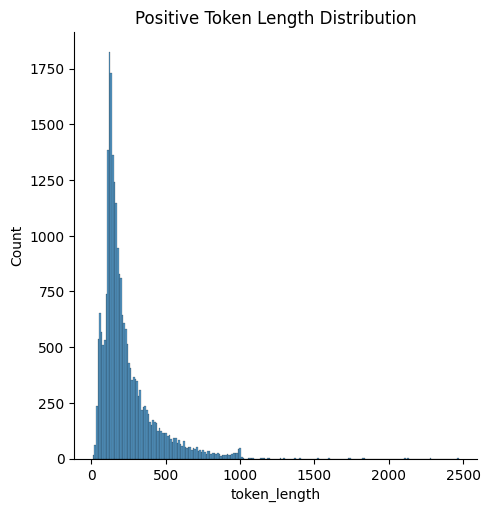

In [ ]:
plt.figure(figsize=(5, 8))
sns.displot(data_pos, x='token_length')
plt.title('Positive Token Length Distribution')
plt.show()

<Figure size 500x800 with 0 Axes>

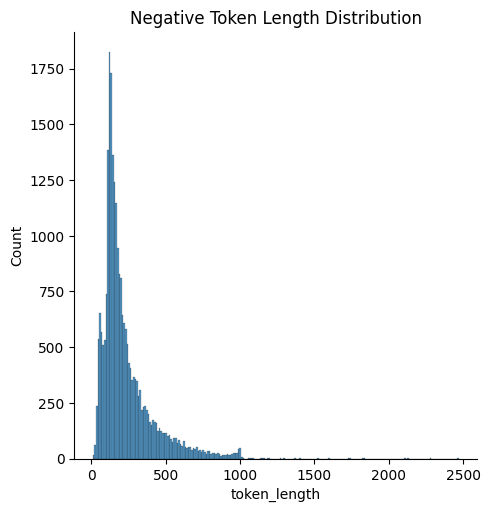

In [ ]:
plt.figure(figsize=(5, 8))
sns.displot(data_pos, x='token_length')
plt.title('Negative Token Length Distribution')
plt.show()

Now let's see some reviews from positive and negative reviews.

In [ ]:
# see most minimum length token
print('Positive')
print(data_pos[data_pos['token_length'] == data_pos['token_length'].min()]['review'].item())
print()
print('Negative')
print(data_neg[data_neg['token_length'] == data_neg['token_length'].min()]['review'].item())

Positive
Brilliant and moving performances by Tom Courtenay and Peter Finch.

Negative
Primary plot!Primary direction!Poor interpretation.


## Clean and Preprocess
1. Create text cleaning method pipeline
2. Create text preprocessing method pipeline
3. Save preprocessed data as new csv file

Here we will define text cleaning pipeline which consist of several methods below:
1. Remove links
2. Remove punctuations, but here we exclude dot (.), comma (,), hyphen (-), exclamation (!), and question mark(?).
3. Remove HTML tags
4. Space between punctuation, because we want to treat some excluded punctuations as individual token
5. Remove numbers
6. Remove additional whitespaces
7. Remove nonascii characters
8. Remove emoji

In [ ]:
# text cleaning

def rm_link(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

# handle case like "shut up okay?Im only 10 years old"
# become "shut up okay Im only 10 years old"
def rm_punct2(text):
    # return re.sub(r'[\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)
    return re.sub(r'[\"\#\$\%\&\'\(\)\*\+\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)

def rm_html(text):
    return re.sub(r'<[^>]+>', '', text)

def space_bt_punct(text):
    pattern = r'([.,!?-])'
    s = re.sub(pattern, r' \1 ', text)     # add whitespaces between punctuation
    s = re.sub(r'\s{2,}', ' ', s)        # remove double whitespaces
    return s

def rm_number(text):
    return re.sub(r'\d+', '', text)

def rm_whitespaces(text):
    return re.sub(r' +', ' ', text)

def rm_nonascii(text):
    return re.sub(r'[^\x00-\x7f]', r'', text)

def rm_emoji(text):
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)

def spell_correction(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

def clean_pipeline(text):
    no_link = rm_link(text)
    no_html = rm_html(no_link)
    space_punct = space_bt_punct(no_html)
    no_punct = rm_punct2(space_punct)
    no_number = rm_number(no_punct)
    no_whitespaces = rm_whitespaces(no_number)
    no_nonasci = rm_nonascii(no_whitespaces)
    no_emoji = rm_emoji(no_nonasci)
    spell_corrected = spell_correction(no_emoji)
    return spell_corrected

Now, after clean the texts we will proceed to preprocessing methods. Here we will define several preprocessing methods as follows:
1. Tokenize, where we split the text by words using `nltk` package
2. Remove stopwords. Here we will use English stopwords provided by `nltk`
3. Lemmatization, where we transform words into its original form by removing their suffix

In [ ]:
# preprocessing
def tokenize(text):
    return word_tokenize(text)

def rm_stopwords(text):
    return [i for i in text if i not in stopwords]

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(t) for t in text]
    # make sure lemmas does not contains sotpwords
    return rm_stopwords(lemmas)

def preprocess_pipeline(text):
    tokens = tokenize(text)
    no_stopwords = rm_stopwords(tokens)
    lemmas = lemmatize(no_stopwords)
    return ' '.join(lemmas)

In [ ]:
data['clean'] = data['review'].progress_apply(clean_pipeline)
data['processed'] = data['clean'].progress_apply(preprocess_pipeline)
data.head()

100%|██████████| 50000/50000 [02:34<00:00, 322.81it/s]


,review,sentiment,label,token_length,clean,processed
0,One of the other reviewers has mentioned that ...,positive,1,307,One of the other reviewers has mentioned that ...,One reviewer mentioned watching Oz episode hoo...
1,A wonderful little production. <br /><br />The...,positive,1,162,A wonderful little production . The filming te...,A wonderful little production . The filming te...
2,I thought this was a wonderful way to spend ti...,positive,1,166,I thought this was a wonderful way to spend ti...,I thought wonderful way spend time hot summer ...
3,Basically there's a family where a little boy ...,negative,0,138,Basically there s a family where a little boy ...,Basically family little boy Jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,230,Petter Mattei s Love in the Time of Money is a...,Petter Mattei Love Time Money visually stunnin...


Finally, after doing data preprocessing, we save our processed dataset into a new csv file for further usage.

In [ ]:
# keep only processed and label columns
# data[['processed', 'label']].to_csv('./imdb_processed.csv', index=False, header=True)
processed_data = data[['processed', 'label']]
processed_data.head()

,processed,label
0,One reviewer mentioned watching Oz episode hoo...,1
1,A wonderful little production . The filming te...,1
2,I thought wonderful way spend time hot summer ...,1
3,Basically family little boy Jake think zombie ...,0
4,Petter Mattei Love Time Money visually stunnin...,1


## Prepare Dataset
<br>

By now we already have our processed data. Before we proceed to classification step, we need to transform our text into vector representations. And in order to do that, we need to build a vocabulary that maps each token to ids.
<br>

Here are the following steps that we will do:

1. Transform reviews using CountVectorizer
2. Explore our vectorized data (optional)
3. Make train test val split

In [ ]:
vectorizer = CountVectorizer()

In [ ]:
# transform processed text into vector
X = vectorizer.fit_transform(processed_data['processed'])

# separate our label data
y = processed_data['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# examine the splitted size
X_train, X_test

(<40000x96113 sparse matrix of type '<class 'numpy.int64'>'
 	with 4007320 stored elements in Compressed Sparse Row format>,
 <10000x96113 sparse matrix of type '<class 'numpy.int64'>'
 	with 1007394 stored elements in Compressed Sparse Row format>)

## Modelling

In [ ]:
# train model
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# predict our test set
y_pred = rfc.predict(X_test)

# get our model accuracy
accuracy = accuracy_score(y_pred, y_test)
print(f"Our model accuracy: {(accuracy * 100)}%")

Our model accuracy: 86.06%


## Evaluation Metrics

In [ ]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      5011
           1       0.86      0.87      0.86      4989

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



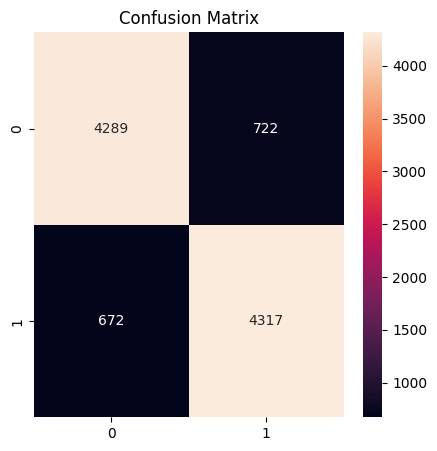

In [ ]:
cm = confusion_matrix(y_pred, y_test)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.show()

According to the classification report it can be seen that our accuracy is not tends to fall into specific class. And the confusion matrix also shown that there is no big difference between misclassified positive and negative reviews. This may happens because we have a balance datasets.

## Conclusion
To sum up, here what we did along the project:
- We taken IMDB movie review from kaggle consist of 50K positive and negative reviews and fortunately it has balance dataset.
- We transform our label into 1 and 0 for positive and negative class respectively
- We create our own cleaning and preprocessing script
- Then we built vocabulary, encoding all reviews, add padding/trimming mechanism, making train test and validation set, create dataloader to make batches data
- Then we transform our preprocessed text data into vector, making train and test split with ratio 80:20 for train and test split respectively.
- Finally, we see our model evaluation using various metrics and plotting confusion matrix which showing that our model could classify most data correctly and not tends to specific class as we have balanced dataset.

### References:
- [Udacity - Introduction to PyTorch](https://classroom.udacity.com/courses/ud188)
- [The Unreasonable Effectiveness of RNNs by Andrej Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
- [PyTorch Name Classification project](https://github.com/python-engineer/pytorch-examples/tree/master/rnn-name-classification)
- [My exploration project in RNNs](https://github.com/fhrzn/all-about-rnn)

<hr>

## Thank you for reading! Спасибо! 🙇‍♂️
```Made with effort by Affandy Fahrizain```

My other projects:
- Github - [https://github.com/fhrzn/all-about-rnn](https://github.com/fhrzn/all-about-rnn)

For further discussion, don't hesitate to catch me up at:
- Gmail - [fahri.lafa@gmail.com](mailto:fahri.lafa@gmail.com)
- Linkedin - [linkedin.com/in/fahrizainn](linkedin.com/in/fahrizainn)